# Big Data in Business and Industry: Practical Assignment

This notebook covers pre-processing and feature engineering given sports tracking data, and planning a machine learning model for forecasting the user’s next exercise type, time and duration.

## Pre-processing Data

The data contains information of every sport event recorded by one person from 2017 to 2020. The original data contained 3456 events as .json files. When a data frame is created, every index should have 19 observations. However, it can be seen that the data contains a lot of missing (NaN) values. 

In [46]:
# Basis for the code in this cell was given in Moodle as 'READ_workoutsToMoodle.py'

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px

folder = 'E:/Koulu/Big Data in Business and Industry/Practical Assignment/WorkoutData_2017to2020'
file_list = os.listdir(folder)

def read_file_to_df(filename):
    data = pd.read_json(filename, typ='series')
    value = []
    key = []
    for j in list(range(0, data.size)):
        if list(data[j].keys())[0] != 'points':
            key.append(list(data[j].keys())[0])
            value.append(list(data[j].items())[0][1])
            dictionary = dict(zip(key, value))
       

    if list(data[j].keys())[0] == 'points':
        try:
            start = list(list(list(data[data.size-1].items()))[0][1][0][0].items())[0][1][0]
            dictionary['start_lat'] = list(start[0].items())[0][1]
            dictionary['start_long'] = list(start[1].items())[0][1]
            dictionary['end_lat'] = list(start[0].items())[0][1]
            dictionary['end_long'] = list(start[1].items())[0][1]
        except:
            pass
        
    df = pd.DataFrame(dictionary, index = [0])

    return df

# Main dataframe 
df_sports = pd.DataFrame()

# Read files to a common dataframe
for filename in file_list:
    df_process = read_file_to_df(folder +'/'+ filename)
    df_sports = pd.concat([df_sports, df_process], 0)

# Reset indexing of the dataframe
df_sports.reset_index(drop=True, inplace = True)

# Example of NaN -values in the dataframe
print(df_sports.loc[[29]])

        sport               source           created_date  \
29  BADMINTON  INPUT_MANUAL_MOBILE  2017-01-11 20:01:18.0   

               start_time               end_time  duration_s  distance_km  \
29  2017-01-11 18:00:00.0  2017-01-11 19:00:00.0        3600          0.0   

    calories_kcal  altitude_min_m  altitude_max_m  speed_avg_kmh  \
29        540.833             NaN             NaN            0.0   

    speed_max_kmh  ascend_m  descend_m  start_lat  start_long  end_lat  \
29            NaN       NaN        NaN        NaN         NaN      NaN   

    end_long  hydration_l  
29       NaN          NaN  


When starting the pre-processing of the data, exercise 'RUNNING_CANICROSS' is set to be equal to 'RUNNING' in the main dataframe 'df_sports', as it was instructed in the course lecture. Pre-processing is then continued by dropping out all rows with NaN-values. This method is not usually recommended, but in this case, it made the most sense to prepare the data for a machine learning model this way. The data was recorded with sports tracking software Endomondo, and so the missing values can occur due to interruptions in the data flow or user errors, for example. Rençberoğlu (2019) explains in an article written for Towards Data Science that most machine learning models do not accept datasets with missing values (they will result in an error) but dropping out missing values will reduce the training set size, thus decreasing the model performance.

Other methods for fixing missing values could be replacing them by using methods such as numerical or categorical imputation, but they would have corrupted this type of data, where each observation is a unique record of an actual exercise (Rençberoğlu, 2019). For example, a missing value for hydration cannot be replaced neither with zero nor an average value (etc.) of other occurrences, because the need for hydration depends on each individual session. Conclusions cannot be made from corrupted data, and forecasting with a machine learning method would be inaccurate. 

The pre-processing  also includes dropping out exercises with less than 12 occurrences, because there is not enough data for a machine learning model and doing something less than once a month in a year reduces the factor of attractiveness. After this, there are 6 exercises left.

In [48]:
# ChatGPT was utilized in the creation of this code

# 'RUNNING_CANICROSS' = 'RUNNING'
df_sports['sport'] = df_sports['sport'].replace('RUNNING_CANICROSS', 'RUNNING')

# Remove instances with NaN-values
df_sports.dropna(inplace=True)

# Remove sports with less than 12 instances
sport_counts = df_sports['sport'].value_counts()
df_sports = df_sports[df_sports['sport'].isin(sport_counts.index[sport_counts >= 12])]
 
df_sports.reset_index(drop=True, inplace = True)

# Display the exercises (and their occurences) in column 'sport'
occur = df_sports.groupby(['sport']).size() 
display(occur)

sport
CYCLING_SPORT               32
CYCLING_TRANSPORTATION      54
ICE_SKATING                 26
RUNNING                     91
SKIING_CROSS_COUNTRY        59
WALKING                   1952
dtype: int64

## Feature Engineering

The wanted machine learning model should be able to forecast the user's next exercise type, time and duration. Keeping this in mind, the conducted feature engineering in this case composes of exctracting features, categorizing, one-hot encoding, and finally clustering them.

Extracting features includes creating new variables from exsisting ones: Duration of the exercise in minutes ('duration_min') is created by dividing duration in seconds -variable ('duration_s') with 60. The day of the week of the exercise ('day_of_week') is extracted from the start time of the exercises ('start_time') by using dt.day_name() method, which returns the name of the day of the week for a given datetime object. For using this method, all the date variables are converted to datetime objects using pd.to_datetime() method. Lastly, the hour of the day of the exercise ('hour_of_day') is extracted from start time of the exercises.

In [49]:
# ChatGPT was utilized in the creation of this code

# Feature Extraction:

# Convert date/time -related columns to datetime objects
df_sports['start_time'] = pd.to_datetime(df_sports['start_time'])
df_sports['created_date'] = pd.to_datetime(df_sports['created_date'])
df_sports['end_time'] = pd.to_datetime(df_sports['end_time'])

# Create a new column for the duration in minutes feature
df_sports['duration_min'] = df_sports['duration_s'] / 60

# Create a new column for the day of the week feature
df_sports['day_of_week'] = df_sports['start_time'].dt.day_name()

# Create a new column for the hour of the day feature
df_sports['hour_of_day'] = df_sports['start_time'].dt.hour

df_sports.reset_index(drop=True, inplace = True)

# Display an example of the new columns
print(df_sports[[df_sports.columns[0], df_sports.columns[2], df_sports.columns[3], df_sports.columns[19], df_sports.columns[20], df_sports.columns[21]]].iloc[0])

sport                       WALKING
created_date    2018-02-07 13:50:42
start_time      2018-02-07 13:50:41
duration_min              30.116667
day_of_week               Wednesday
hour_of_day                      13
Name: 0, dtype: object


Next, three categorical variables are created: every exercise event is categorized by the season of the year ('season') based on their start time, the observations in duration in minutes are categorized based on how long the exercising lasted ('duration_c'), and the hour of day feature is categorized as time of the day ('time_of_day'). Categorization by the season is done by using the map method, where the month of each date is mapped to a season using the dictionary provided. The other two categories use the binning method with specified bin intervals. 

In [50]:
# ChatGPT was utilized in the creation of this code

# Categorizing:

# Create a new column for the seasons
# Dictionary: months 3-5 = spring, 6-8 = summer, 9-11 = fall, 12-2 = winter 
df_sports['season'] = df_sports['start_time'].dt.month.map({3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'fall', 10: 'fall', 11: 'fall', 12: 'winter', 1: 'winter', 2: 'winter'})

# Create a pivot table for showing the number of each exercise in each season
df_grp_season = df_sports.groupby(['season', 'sport']).size().reset_index(name='count')
df_pivot_season = df_grp_season.pivot(index='season', columns='sport', values='count')
print(df_pivot_season)

# Create a new column for the duration category of each exercise
# Bins: first bin includes all exercises with a duration less than or equal to
# 30 minutes (= short),
# second bin includes all exercises with a duration between
# 30 and 60 minutes (= medium), 
# third bin includes all exercises with a duration greater than
# 60 minutes (= long)
df_sports['duration_c'] = pd.cut(df_sports['duration_min'], bins=[0, 30, 60, float('inf')], labels=['short', 'medium', 'long'])

# Create a pivot table for showing the number
# of each exercise in each duration category
df_grp_duration = df_sports.groupby(['duration_c', 'sport']).size().reset_index(name='count')
df_pivot_duration = df_grp_duration.pivot(index='duration_c', columns='sport', values='count')
print(df_pivot_duration)

# Define time intervals for the time of the day:
# Night = 0-3 o'clock, Morning = 4-10 o'clock, Day = 11-13 o'clock,
# Afternoon = 14-16 o'clock, Evening = 17-23 o'clock 
time_bins = [0, 3, 10, 13, 16, 23]
time_labels = ['Night', 'Morning', 'Day', 'Afternoon', 'Evening']

# Create a new column with the time intervals
df_sports['time_of_day'] = pd.cut(df_sports['hour_of_day'], bins=time_bins, labels=time_labels)

# Create a pivot table for showing the number
# of each exercise during each time of the day
df_grp_time = df_sports.groupby(['time_of_day', 'sport']).size().reset_index(name='count')
df_pivot_time = df_grp_time.pivot(index='time_of_day', columns='sport', values='count')
print(df_pivot_time)

df_sports.reset_index(drop=True, inplace = True)

sport   CYCLING_SPORT  CYCLING_TRANSPORTATION  ICE_SKATING  RUNNING  \
season                                                                
fall              1.0                    18.0          NaN     32.0   
spring            4.0                    17.0         23.0     20.0   
summer           27.0                    19.0          NaN     31.0   
winter            NaN                     NaN          3.0      8.0   

sport   SKIING_CROSS_COUNTRY  WALKING  
season                                 
fall                     3.0    485.0  
spring                  29.0    530.0  
summer                   NaN    488.0  
winter                  27.0    449.0  
sport       CYCLING_SPORT  CYCLING_TRANSPORTATION  ICE_SKATING  RUNNING  \
duration_c                                                                
short                   4                      50           12        7   
medium                 14                       4           12       62   
long                   14        

The first table shows that many of the exercises are done evenly throughout most of the year (for example cycling transportation), and only two exercises can be done no matter the season, walking and running (no missing values). The second table shows that medium (30 to 60 minutes) is the most popular duration for the exercises. The last table shows that, perhaps suprisingly, most of the exercising is not done during evening hours.

Before creating the final datarame with one-hot encoding, varibles with no apparent use are removed.

In [51]:
# ChatGPT was utilized in the creation of this code

# Remove columns 'source','created_date','start_time',
# 'end_time','duration_s','distance_km',
# 'altitude_min_m','altitude_max_m','speed_avg_kmh',
# 'speed_max_kmh','ascend_m','descend_m'
df_sports = df_sports.loc[:, ~df_sports.columns.isin(['source','created_date','start_time','end_time','duration_s','distance_km','altitude_min_m',
'altitude_max_m','speed_avg_kmh','speed_max_kmh','ascend_m','descend_m',])]

df_sports.reset_index(drop=True, inplace = True)

One-hot encoding is used to convert categorical variables into numerical ones as numerical input is wanted for clustering and the machine learning model. Panda's get_dummies() method converts each variable's values to either 0 or 1, and the columns in the final dataframe are named after the categories.

In [52]:
# ChatGPT was utilized in the creation of this code

# One-hot encode categorical variables:
#'sport', 'day_of_week', 'season', 'duration_c', 'time_of_day'

df_sports_encoded = pd.get_dummies(df_sports, columns=['sport', 'day_of_week', 'season', 'duration_c', 'time_of_day'])

Finally, the encoded dataframe is used in clustering the data with K-means method. Initially, the number of clusters is set to 3. Then fit() method performs the clustering identifying the three clusters. Lastly, the resulting cluster labels are added to the original dataframe as a new column named 'cluster'. The cluster labels are added to the original dataframe instead of the encoded one, because it contains the actual data that was used for clustering. Below is an example visualization of the clusters: It can be seen that the user's low calory burning exercises have been done throughout the day, medium calory burning exercises have been done from very early in the morning to early in the evening, and high calory burning exercises are mostly done between morning and afternoon. It can also been seen that three was enough for the number of clusters.

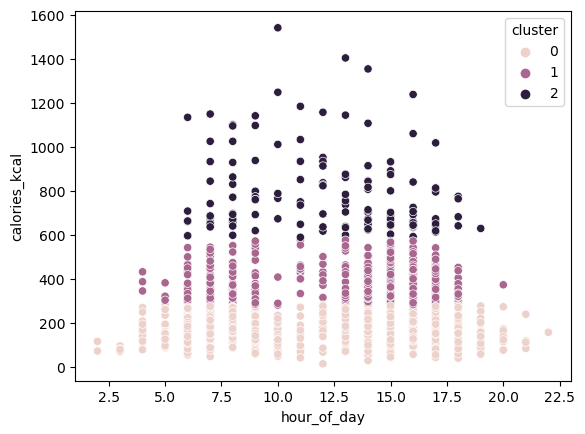

In [53]:
# ChatGPT was utilized in the creation of this code

# Clustering:

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_sports_encoded)

# Add cluster labels to the original data frame
df_sports['cluster'] = kmeans.labels_

# Create a scatter plot
sns.scatterplot(x='hour_of_day', y='calories_kcal', hue='cluster', data=df_sports)
plt.show()

## Visualizing Data


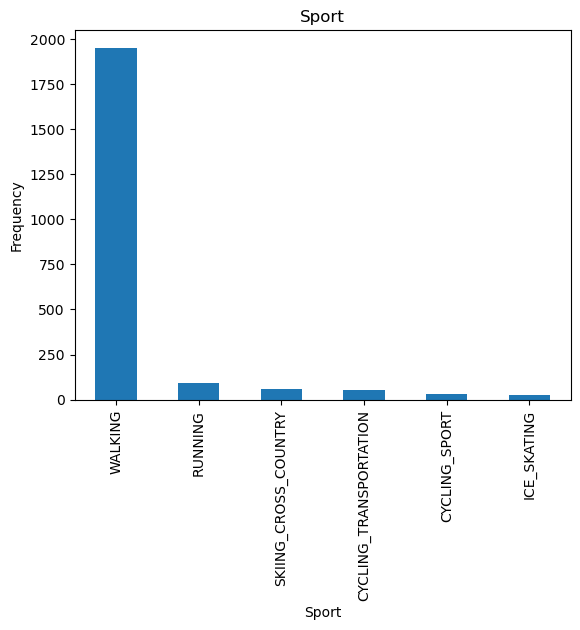

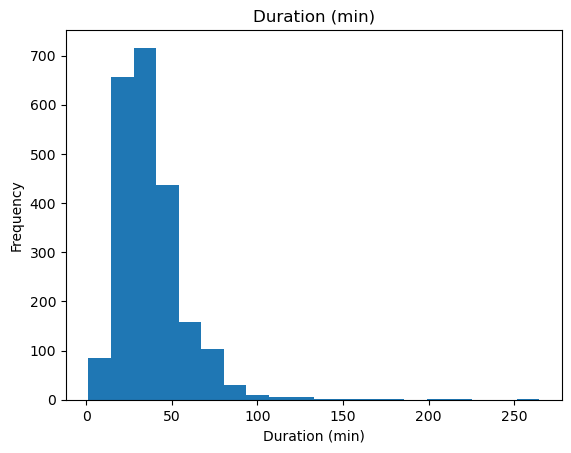

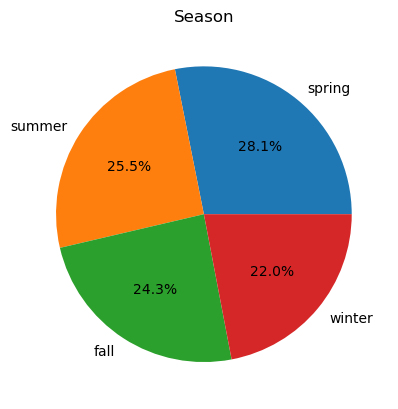

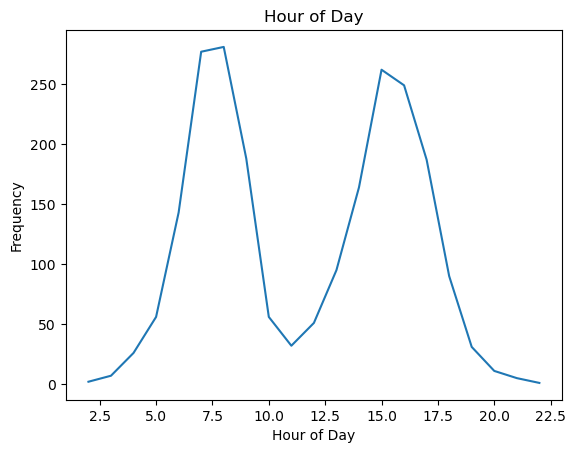

In [54]:
# ChatGPT was utilized in the creation of this code

# Select columns for visualization
df_vis = df_sports[['sport', 'duration_min', 'season', 'hour_of_day']]

# Plot the sport column as a bar chart
df_vis['sport'].value_counts().plot(kind='bar')
plt.title('Sport')
plt.xlabel('Sport')
plt.ylabel('Frequency')
plt.show()

# Plot the duration_min column as a histogram
df_vis['duration_min'].plot(kind='hist', bins=20)
plt.title('Duration (min)')
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.show()

# Plot the season column as a pie chart
df_vis['season'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Season')
plt.ylabel('')
plt.show()

# Plot the hour_of_day column as a line chart
df_vis.groupby('hour_of_day').size().plot(kind='line')
plt.title('Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

The plots created above provide information of the user’s exercising habits. In the first image, Sport, it can be seen that most of the gathered data is from walking.  In the second image, Duration (min), the distribution of the histograms show that the user has exercised for about 30 minutes the most frequently. This supports the fact that duration category ‘medium’ can be seen as the most popular one from the printed table. In the third image, Season, the pie chart shows that the user has exercised almost the same amount during each season. The last image, Hour of Day, illustrates well when most of the exercises occur (in the morning and afternoon) and during which hours of the day exercising is less likely (around 11 o'clock).

## Plan for the Machine Learning Model

In the case of wanting to forecast the user’s next exercise, time and duration based on the data, a supervised machine learning model should be used. These models utilize the data in teaching the algorithm with the correct outputs.

First, the data from the one-hot encoded dataframe is split to training and test data with a ratio of 70/30 or 80/20. The training set is used to train the model and the test set is used to test the model. Python has a machine learning toolkit called Scikit learn, which comes with a train_test_split function (Ebner, 2022a).

Second, the machine learning model is chosen. In this case, when there is a limited amount of data, the algorithm of the model would be simpler as well. For example, using a neural network is out of the question since it would require a lot more data. 

Third, the Scikit learn’s fit() method is used to train the algorithm with the training data (Ebner, 2022a). The same method was also used in identifying the clusters in K-means method earlier.

Fourth, it is time to test the model. For this, the Scikit learn has a predict() method (Ebner, 2022b).

Lastly, the performance of the model could be evaluated by using confusion matrix, which provides values for the cases of true positives, false positives, true negatives, and false negatives. The Scikit learn also has a method for this, metrics.confusion_matrix(). These values can be used in the calculation of the model’s accuracy, precision, sensitivity, and specificity.

## List of References

Ebner, J. (2022a) A Quick Introduction to the Sklearn Fit Method. Sharp Sight (blog text). (Accessed 31.10.2023). Available at:
https://www.sharpsightlabs.com/blog/sklearn-fit/

Ebner, J. (2022b) How to Use the Sklearn Predict Method. Sharp Sight (blog text). (Accessed 31.10.2023). Available at:
https://www.sharpsightlabs.com/blog/sklearn-predict/

Rençberoğlu, E. (2019) Fundamental Techniques of Feature Engineering for Machine Learning. Towards Data Science (online website). (Accessed 25.10.2023). Available at:
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114